# We will use this notebook to create a final table, out of the three "clean" tables we have in DBeaver

In [1]:
# import all libraries that are needed

import requests                 # requests on websites
from bs4 import BeautifulSoup   # html parsing

import pandas as pd             # pandas for data frame
import numpy as np              # numpy for array

import math                     # for math methods
import time                     # for sleep timer


from sql_functions import *     # functions from file for upload on schema
import psycopg2                 # for upload on engine

# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

# Import get_dataframe from sql_functions.py
from sql_functions import get_dataframe

# create a variable called engine using the get_engine function
engine = get_engine()

import datetime                 # for date and time
import datetime as dt           # for the csv file with the current date and time
from datetime import date       # for the current date

import re                       # for regular expressions

# https://jsonformatter.org/json-viewer
import json                     # for json files

import random                   # for random numbers

# https://jwalton.info/Matplotlib-custom-boxplots/
import itertools

import matplotlib.pyplot as plt # for plotting
# Will allow us to embed images in the notebook
%matplotlib inline
from matplotlib.cbook import _reshape_2D

# Seaborn visualization library
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
import seaborn as sns

# Things we have to do in the final table, to get a decent database

In [ ]:
# we check the rows before dropping
plot_df.loc[(plot_df.property_type == 'Apartment')
                | ( plot_df.property_type == 'Flat' )
                | ( plot_df.property_type == 'Block of Apartments' )
                | ( plot_df.property_type == 'Flat' )
                | ( plot_df.property_type == 'Ground Flat' )
                | ( plot_df.property_type == 'Penthouse' )
                | ( plot_df.property_type == 'Studio') 
            ]
display(plot_df.head(2))

In [ ]:
# we drop our rows
df_short = plot_df.loc[(plot_df.property_type == 'Apartment')
                | ( plot_df.property_type == 'Flat' )
                | ( plot_df.property_type == 'Block of Apartments' )
                | ( plot_df.property_type == 'Flat' )
                | ( plot_df.property_type == 'Ground Flat' )
                | ( plot_df.property_type == 'Penthouse' )
                | ( plot_df.property_type == 'Studio') 
            ]

In [ ]:
df_short.property_type.unique()

In [ ]:
df_short.loc[
                        (
                            (df_short.price < 8001) & (df_short.furniture == 'furnished')
                         | ( df_short.furniture == 'unfurnished'
                            )
                            )]
display(df_short.head(2))

In [ ]:
df_short = df_short.loc[
                        (
                            (df_short.price < 8001) & (df_short.furniture == 'furnished')
                         | ( df_short.furniture == 'unfurnished'
                            )
                            )]

In [ ]:
df_short.head(2)

# Give the  data back to DBeaver to use it in Tableau

In [ ]:
# # Delete platforms_complete_4 table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.platforms_complete_4;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [ ]:
# # call the schema created for this project
schema = 'capstone_jmrs'

# give the table a unique name
table_name = 'platforms_complete_4'

# import the table to sql
if engine != None:
    try:
        df_short.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

# JULIA

### Merging the _clean tables

In [ ]:
sql_text = f"""
CREATE TABLE platforms_complete AS
(SELECT *
 FROM spotahome_clean
 UNION
 SELECT *
 FROM blueground_clean
 UNION
 SELECT *
 FROM rightmove_clean);
 """
result = engine.execute(sql_text)


### copy the 'old' table instead of overwriting

In [ ]:
sql_text = f"""
SELECT *
INTO platforms_complete_5
FROM platforms_complete_3;å
"""
result = engine.execute(sql_text)

### delete every property type that is not an Apartment, Flat, Studio etc

In [ ]:
sql_text = f"""
DELETE
FROM platforms_complete_5
WHERE property_type != 'Apartment'
	AND property_type != 'Block of Apartments'
	AND property_type != 'Flat'
	AND property_type != 'Ground Flat'
	AND property_type != 'Penthouse'
	AND property_type != 'Studio';
"""
result = engine.execute(sql_text)


### delete every property that is above £8000 for furnished apartments

In [ ]:
sql_text = f"""
DELETE
FROM platforms_complete_5
WHERE furniture = 'furnished'
	AND price > '8001';
"""
result = engine.execute(sql_text)

### delete every property that is above £xxxx for unfurnished apartments

In [ ]:
sql_text = f"""
DELETE
FROM platforms_complete_5
WHERE furniture = 'unfurnished'
	AND price > 'xxxx';
"""
result = engine.execute(sql_text)

-----

# We will plot some graphes with the final data

In [2]:
# Schema / Database configure:
schema = 'capstone_jmrs'

# Table name:
table_name = 'platforms_complete'


In [3]:
# Select the combined Data form DBeaver Database

sql = f"""
SELECT *
FROM {schema}.{table_name} as platforms_complete_5
""" 
# Take the SQL-Command and import all Data into the variable df
platforms_complete = get_dataframe(sql) 
display(platforms_complete.head(3))

,platform_id,platform,neighbourhood,furniture,property_type,size_sqm,bedrooms,bathrooms,price,price_sqm,price_bedroom,available_from,available_today,let_type,detailed_furniture,scraping_date
0,127896770,Rightmove,Lambeth,furnished,Flat,NaN,2.0,2.0,3878.0,NaN,1939.0,2022-10-12,available,Long term,furnished,2022-10-12
1,127460438,Rightmove,Lambeth,furnished,Flat,NaN,1.0,1.0,1560.0,NaN,1560.0,2022-10-12,available,Long term,furnished,2022-10-12
2,85887825,Rightmove,City of Westminster,unfurnished,Flat,NaN,1.0,1.0,2150.0,NaN,2150.0,2022-12-08,occupied,Long term,part furnished,2022-10-12


In [4]:
plot_platforms_complete = platforms_complete

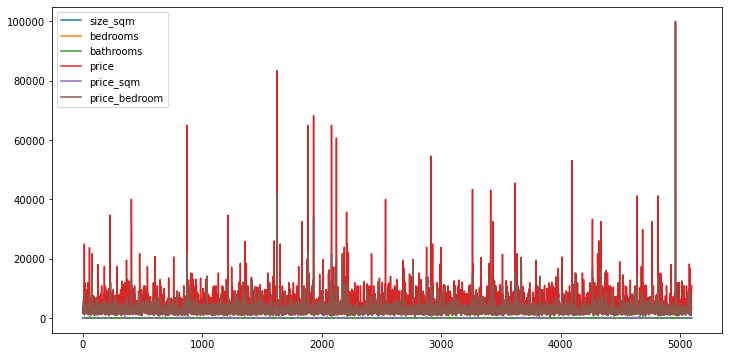

In [5]:
plot_platforms_complete.plot(figsize=(12,6));

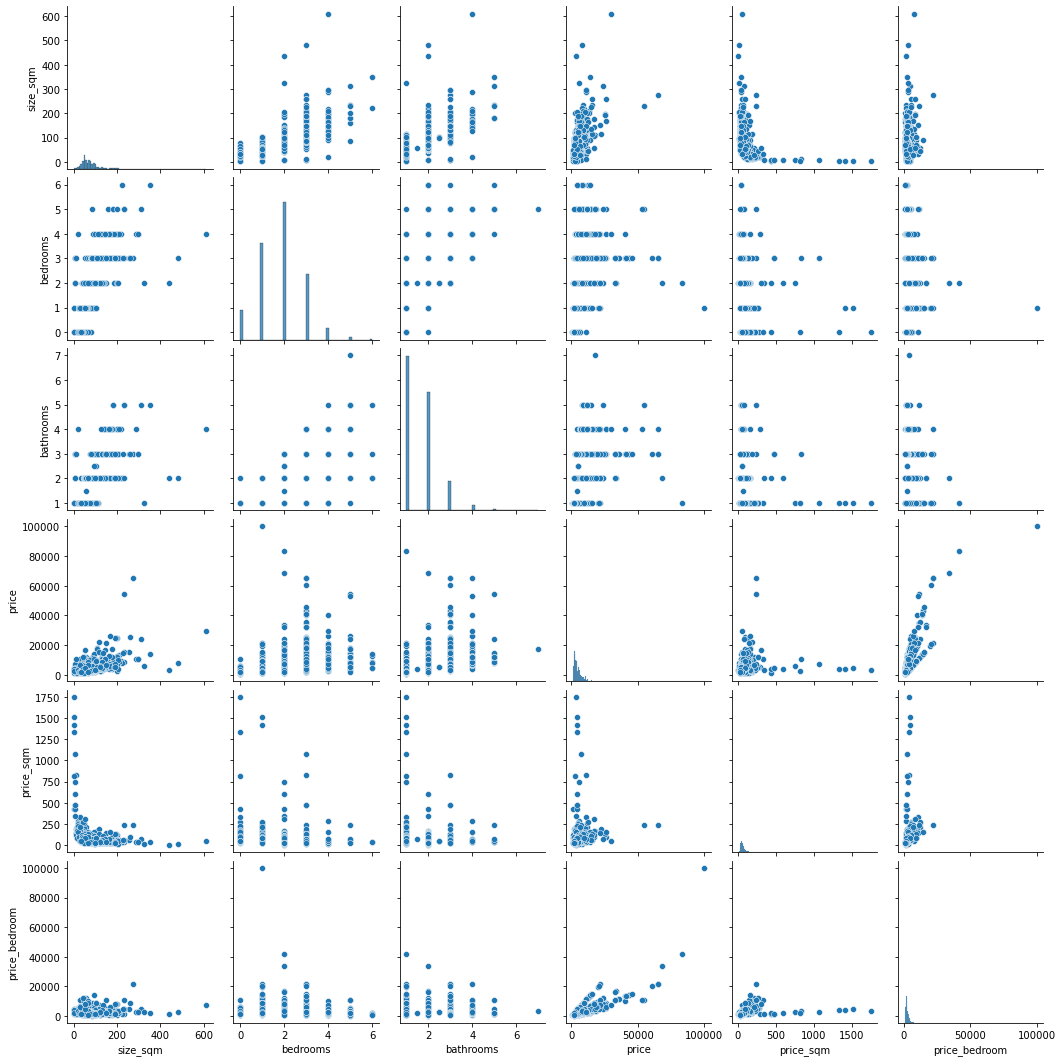

In [6]:
# Create the default pairplot
sns.pairplot(plot_platforms_complete);

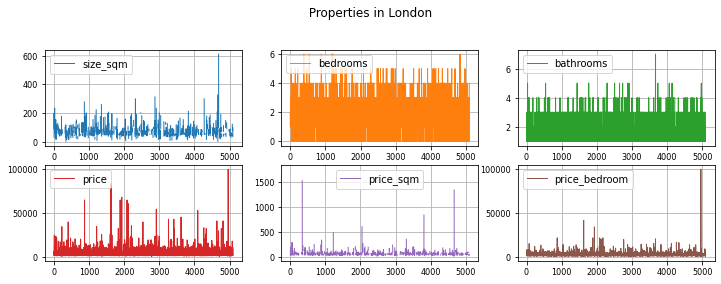

In [7]:
plot_platforms_complete.plot(figsize=(12,6), subplots=True, layout=(3,3), sharex=False, sharey=False, legend=True, fontsize=8, title=' Properties in London', linestyle='solid', linewidth=1, grid=True);

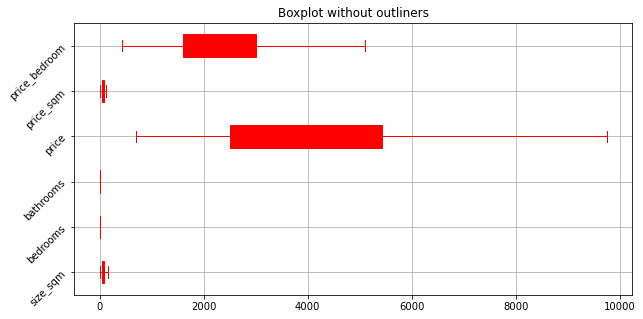

In [8]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot without outliners', color='red', vert=False, patch_artist=True, showfliers=False);

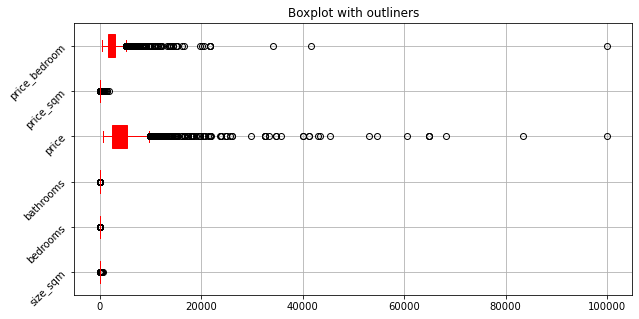

In [9]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot with outliners', color='red', vert=False, patch_artist=True, showfliers=True);

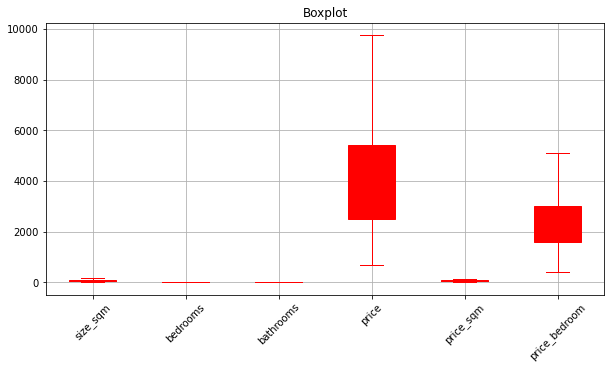

In [10]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=False, subplots=False, sharex=False, sharey=False);

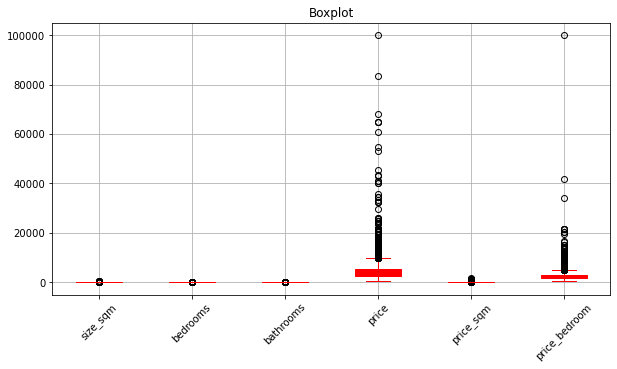

In [11]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

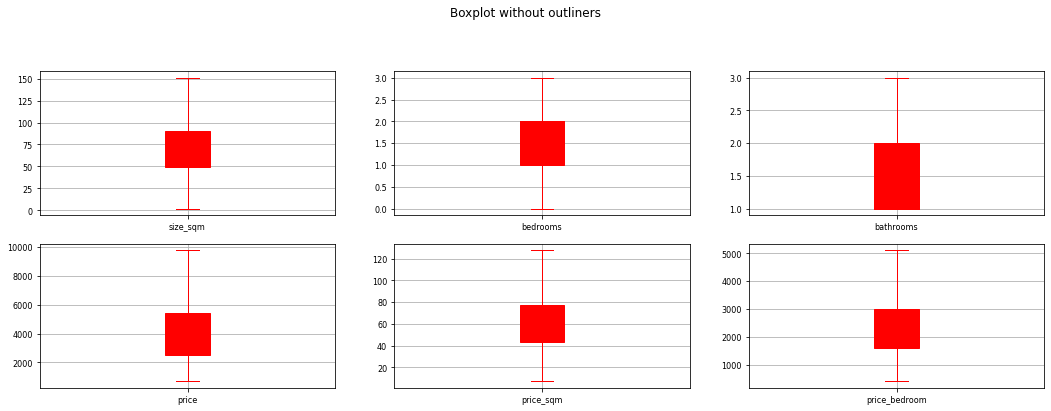

In [12]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_platforms_complete.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot without outliners', color='red', vert=True, patch_artist=True, showfliers=False, subplots=True, layout=(3, 3), legend=True);

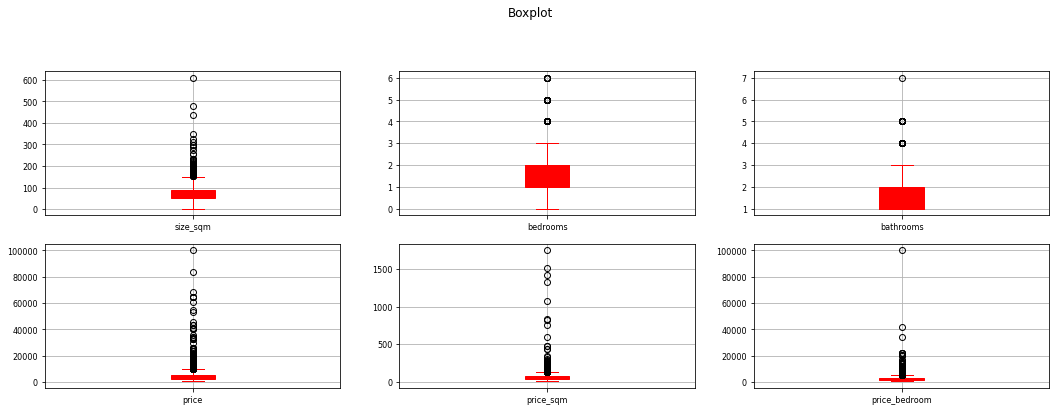

In [13]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True, layout=(3, 3), legend=True);

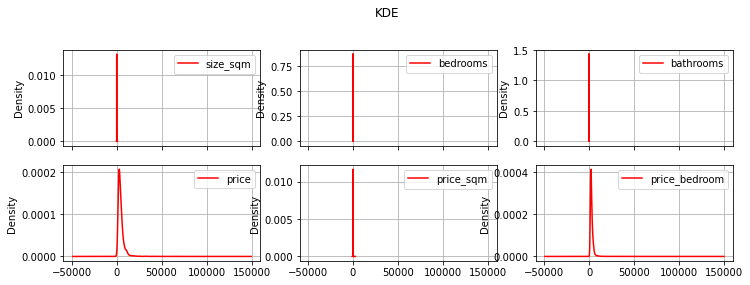

In [14]:
plot_platforms_complete.plot(kind='kde', figsize=(12, 6), fontsize=10, grid=True, title='KDE', color='red', subplots=True, layout=(3, 3), legend=True);

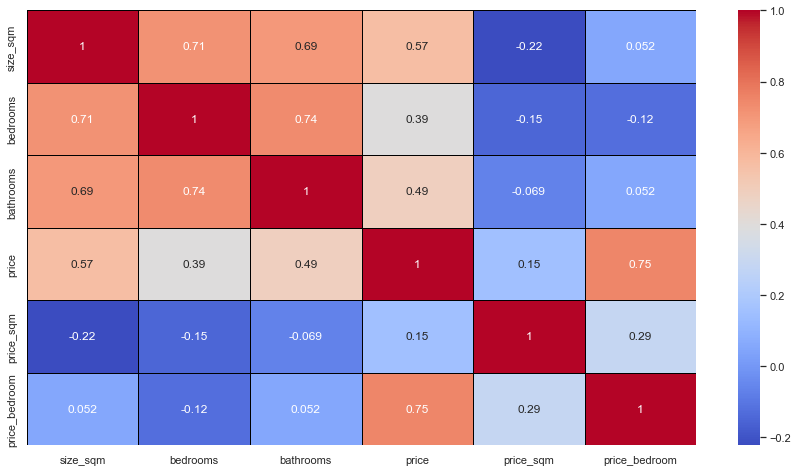

In [15]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(plot_platforms_complete.corr(), annot=True, cmap='coolwarm', linewidths=1, linecolor='black');

In [16]:
sql_text = f"""
SELECT *
FROM capstone_jmrs.platforms_complete AS pc 
WHERE pc.furniture = 'unfurnished'
AND pc.platform = 'Rightmove'
AND pc.neighbourhood = 'City of Westminster' ;
"""
rightmove_unfurniture = get_dataframe(sql_text) 

In [17]:
sql_text = f"""
SELECT *
FROM capstone_jmrs.platforms_complete AS pc 
WHERE pc.furniture = 'furnished'
AND (pc.platform = 'Blueground' or pc.platform = 'Spotahome')
AND pc.neighbourhood = 'City of Westminster' ;
"""
bs_furniture = get_dataframe(sql_text) 

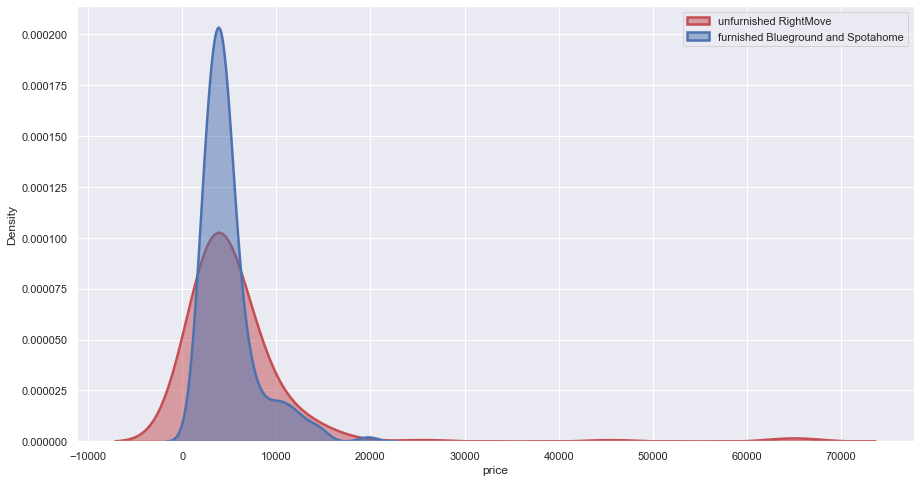

In [18]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(rightmove_unfurniture.price, shade=True, color="r", label='price', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(bs_furniture.price, shade=True, color="b", label='price_bedroom', alpha=0.5, linewidth=2.5, linestyle='solid')
fig.legend(labels=['unfurnished RightMove','furnished Blueground and Spotahome'])
plt.show()